In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# Download the file first
!wget https://raw.githubusercontent.com/jinshijian/SoilHealthDB/master/data/SoilHealthDB_V2.csv

# Read the downloaded CSV file
df = pd.read_csv('SoilHealthDB_V2.csv', encoding='latin-1')

# Display the first few rows to verify
print(df.head())

--2025-07-11 17:44:54--  https://raw.githubusercontent.com/jinshijian/SoilHealthDB/master/data/SoilHealthDB_V2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3545298 (3.4M) [application/octet-stream]
Saving to: ‘SoilHealthDB_V2.csv’

SoilHealthDB_V2.csv 100%[===================>]   3.38M  9.38MB/s    in 0.4s    

2025-07-11 17:44:56 (9.38 MB/s) - ‘SoilHealthDB_V2.csv’ saved [3545298/3545298]

   StudyID ExperimentID Author_F Author_G  YearPublication  SamplingYear  \
0        1        1-Jan    Abawi     G.S.             2000           NaN   
1        1        1-Jan    Abawi     G.S.             2000           NaN   
2        1        2-Jan    Abawi     G.S.             2000           NaN   
3        1        1-Jan    Abawi     G.S.             2000     

/tmp/ipython-input-2-2313439922.py:5: DtypeWarning: Columns (16,19,20,24,25,52,77,122,150,152,160,192,197,212,232,237,242,247,252,262,265,266) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('SoilHealthDB_V2.csv', encoding='latin-1')


## 3. Which crops grow the best in each soil type?

Create a df of the soil types column, the crop column, and the covercrop column, and crop yield if it exists. Remember the db has two on each row. Conventional and covercrop/organic.
Fields to use:
- SoilFamily (soil type is missing a lot of data)
- GrainCropGroup (as there are so many mixed records where it is unclear if they are grown in rotation or both grown regularly)
- CoverCropGroup (as is more important that a cover crop is used, and is difficult to normalise when multiple covercrops are used)
- Yield_C, Yield_T: though the units are not always the same. kg/hm2 unless comments say otherwise, so need comments and remove records where not kg/hm2 (or convert, but there aren't many records of this)

In [3]:
# Create the new dataframe with the specified columns
df_subset = df[[
    'SoilFamily',
    'GrainCropGroup',
    'CoverCropGroup',
    'Yield_C',
    'Yield_T'
]]

# Display the first few rows of the new dataframe
print(df_subset.head())
# Display info about the new dataframe to check for missing values and data types
print(df_subset.info())

  SoilFamily GrainCropGroup CoverCropGroup  Yield_C  Yield_T
0        NaN            MTT         Legume      NaN      NaN
1        NaN            MTT         Legume      NaN      NaN
2        NaN            MTT       Brassica   4862.0   3990.0
3        NaN            MTT         Legume      NaN      NaN
4        NaN            MTT            Rye      NaN      NaN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5907 entries, 0 to 5906
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SoilFamily      4258 non-null   object 
 1   GrainCropGroup  5616 non-null   object 
 2   CoverCropGroup  5062 non-null   object 
 3   Yield_C         2382 non-null   float64
 4   Yield_T         2381 non-null   float64
dtypes: float64(2), object(3)
memory usage: 230.9+ KB
None


As the questions are about soil type and crop, these fields cannot be null

In [4]:
# Remove rows where SoilFamily or GrainCrop is missing
df_subset = df_subset.dropna(subset=['SoilFamily', 'GrainCropGroup', 'Yield_C', 'Yield_T'])

# Display info about the cleaned dataframe to check for missing values
print(df_subset.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1713 entries, 13 to 5906
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SoilFamily      1713 non-null   object 
 1   GrainCropGroup  1713 non-null   object 
 2   CoverCropGroup  1652 non-null   object 
 3   Yield_C         1713 non-null   float64
 4   Yield_T         1713 non-null   float64
dtypes: float64(2), object(3)
memory usage: 80.3+ KB
None


In [ ]:
# Separate the dataframe into two based on yield type
df_T = df_subset.copy()
df_C = df_subset.copy()

# Rename columns to have '_T' and '_C' suffixes
df_T = df_T.rename(columns={'Yield_T': 'Yield'})
df_C = df_C.rename(columns={'Yield_C': 'Yield'})

# Add a new column 'Treatment' to identify the source
df_T['Treatment'] = '_T'
df_C['Treatment'] = '_C'

# Set 'CoverCropGroup' to 'None' for '_C' records
df_C['CoverCropGroup'] = 'None'

# Drop the original yield columns that are no longer needed
df_T = df_T.drop(columns=['Yield_C'])
df_C = df_C.drop(columns=['Yield_T'])

# Concatenate the two dataframes back together
df_subset = pd.concat([df_T, df_C], ignore_index=True)

# Display the first few rows of the combined dataframe
print(df_subset.head())

# Display info about the combined dataframe
print(df_subset.info())

   SoilFamily GrainCropGroup CoverCropGroup    Yield Treatment
0  Haplustoll      Vegetable            Rye  23300.0        _T
1  Haplustoll      Vegetable          Grass  19800.0        _T
2  Haplustoll      Vegetable          Grass  19600.0        _T
3  Haplustoll      Vegetable            Rye  21400.0        _T
4  Haplustoll      Vegetable          Grass  18000.0        _T
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SoilFamily      3426 non-null   object 
 1   GrainCropGroup  3426 non-null   object 
 2   CoverCropGroup  3365 non-null   object 
 3   Yield           3426 non-null   float64
 4   Treatment       3426 non-null   object 
dtypes: float64(1), object(4)
memory usage: 134.0+ KB
None


clean the grain crop groups

In [8]:
print(df_subset['GrainCropGroup'].unique())

['Vegetable' 'Wheat-oat' 'Soybean' 'Sorghum' 'Wheat' 'Corn' 'Corn-oat'
 'Corn-soybean-wheat' 'Corn-soybean' 'Arable' 'Corn-wheat-millet'
 'Corn-wheat' 'Maize' 'Orchard' 'Unknown' 'Pasture']


In [6]:
# df_combined['GrainCropGroup'] = df_combined['GrainCropGroup'].replace(['Corn', 'Soybean', 'Wheat','Arable'], 'Monoculture')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace(['CS','CSO'], 'Corn-soybean')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace('CW', 'Corn-wheat')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace( 'CO', 'Corn-oat')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace('WO', 'Wheat-oat')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace('CWO', 'Corn-wheat-millet')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace('CSW', 'Corn-soybean-wheat')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace(['AVG','Other'], 'Unknown')
df_subset['GrainCropGroup'] = df_subset['GrainCropGroup'].replace(['CV','CVO', 'WV'], 'Vegetable')
df_subset = df_subset[df_subset['GrainCropGroup'] != 'MTT']


print(df_subset['GrainCropGroup'].unique())

['Vegetable' 'Soybean' 'Corn' 'Corn-oat' 'Sorghum' 'Corn-soybean'
 'Corn-soybean-wheat' 'Arable' 'Wheat' 'Wheat-oat' 'Corn-wheat' 'Maize'
 'Orchard' 'Unknown' 'Pasture']


Normalise and scale data

In [10]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to the 'Yield' column
df_subset['Yield_scaled'] = scaler.fit_transform(df_subset[['Yield']])

# Display the first few rows with the new scaled column
print(df_subset.head())

# Display info to check the new column
print(df_subset.info())

   SoilFamily GrainCropGroup CoverCropGroup    Yield Treatment  Yield_scaled
0  Haplustoll      Vegetable            Rye  23300.0        _T      0.250537
1  Haplustoll      Vegetable          Grass  19800.0        _T      0.212903
2  Haplustoll      Vegetable          Grass  19600.0        _T      0.210752
3  Haplustoll      Vegetable            Rye  21400.0        _T      0.230107
4  Haplustoll      Vegetable          Grass  18000.0        _T      0.193548
<class 'pandas.core.frame.DataFrame'>
Index: 3404 entries, 0 to 3425
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SoilFamily      3404 non-null   object 
 1   GrainCropGroup  3404 non-null   object 
 2   CoverCropGroup  3343 non-null   object 
 3   Yield           3404 non-null   float64
 4   Treatment       3404 non-null   object 
 5   Yield_scaled    3404 non-null   float64
dtypes: float64(2), object(4)
memory usage: 186.2+ KB
None


There are a lot of soil types, so to simplify, the eight soil types with the most data will be visualised. It would be good to group the soil and ananlyse it, but a greater knowledge of soil types is needed.

In [53]:
yield_summary = df_subset.groupby("GrainCropGroup")["Yield"].describe()
display(yield_summary)

,count,mean,std,min,25%,50%,75%,max
GrainCropGroup,,,,,,,,
Arable,306.0,2509.983660,2269.252545,231.000,970.75000,2151.5000,2994.25000,13300.000
Corn,1836.0,2994.914352,2752.843685,1.910,1300.00000,2257.0000,3666.25000,19610.000
Corn-oat,82.0,7220.219512,2391.680560,1260.000,6701.00000,7471.0000,8826.00000,10843.000
Corn-soybean,44.0,6702.272727,4099.148445,1700.000,2700.00000,5400.0000,9925.00000,13300.000
Corn-soybean-wheat,6.0,9305.555667,167.590156,9066.667,9186.11075,9355.5555,9433.33375,9466.667
Corn-wheat,2.0,13300.000000,212.132034,13150.000,13225.00000,13300.0000,13375.00000,13450.000
Maize,38.0,2410.157895,2368.133151,152.000,455.00000,1605.0000,3776.50000,7642.000
Orchard,42.0,21847.630714,17405.807204,0.080,13093.75000,18950.0000,23925.00000,72000.000
Pasture,4.0,4425.595000,3274.644370,852.380,2215.59500,4365.0000,6575.00000,8120.000


In [11]:
# Identify rows with non-null 'Yield'
df_subset_with_yield = df_subset.dropna(subset=['Yield'])

top8_soil = df_subset_with_yield['SoilFamily'].value_counts().nlargest(8).index.tolist()

# Create a new dataframe containing only records from the top 8 soil families
df_top8_soil = df_subset_with_yield[df_subset_with_yield['SoilFamily'].isin(top8_soil)].copy()

# Display info about the new dataframe
print(df_top8_soil.info())
print(df_top8_soil['SoilFamily'].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 1270 entries, 0 to 3207
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SoilFamily      1270 non-null   object 
 1   GrainCropGroup  1270 non-null   object 
 2   CoverCropGroup  1270 non-null   object 
 3   Yield           1270 non-null   float64
 4   Treatment       1270 non-null   object 
 5   Yield_scaled    1270 non-null   float64
dtypes: float64(2), object(4)
memory usage: 69.5+ KB
None
['Haplustoll' 'Typic Hapludulfs'
 'Clayey, skeletal, kaolinitic, isohyperthermic oxic paleustalf'
 'Oxic Hapleustalf' 'Ferric Luvisol (FAO)' 'Orthic Ferralsols (FAO)'
 'Ferric luviso!s' 'AlÞsols']


These eight soil types encompass more than a fifth of the records.

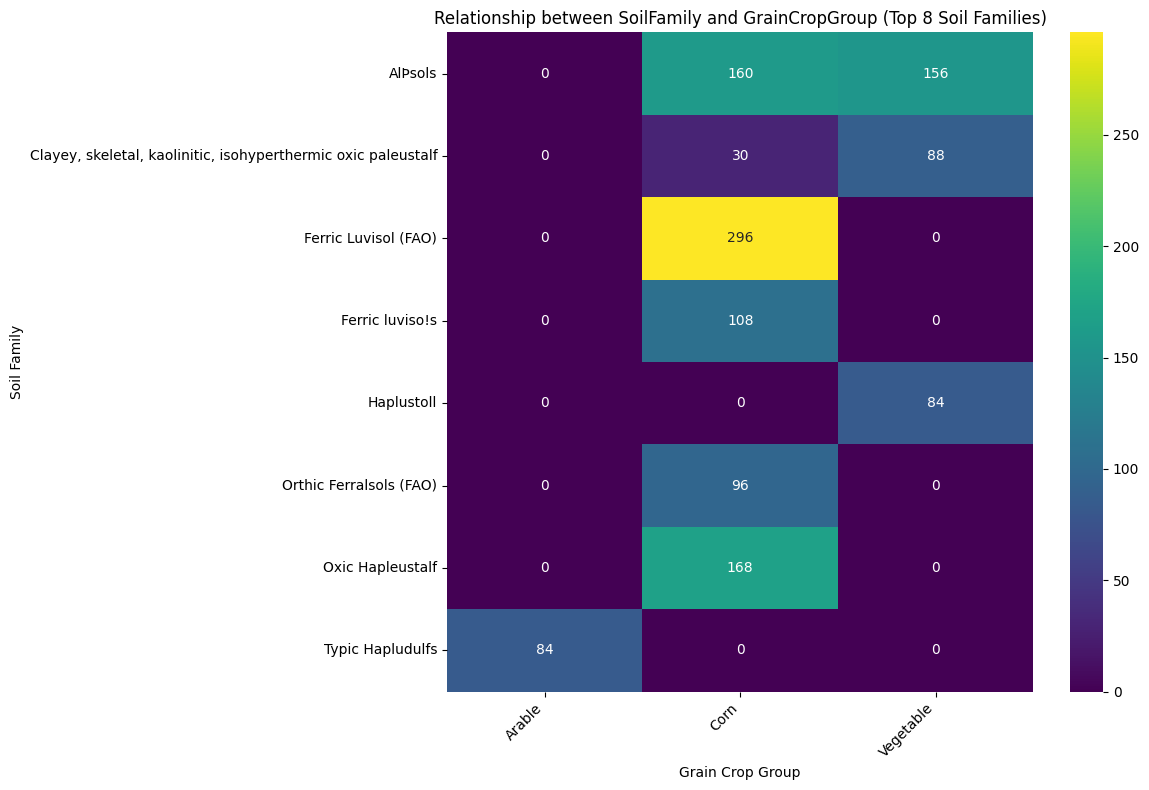

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table to count the occurrences of each GrainCropGroup within each SoilFamily
soil_crop_counts = df_top8_soil.pivot_table(index='SoilFamily', columns='GrainCropGroup', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(soil_crop_counts, annot=True, fmt='d', cmap='viridis')
plt.title('Relationship between SoilFamily and GrainCropGroup (Top 8 Soil Families)')
plt.xlabel('Grain Crop Group')
plt.ylabel('Soil Family')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The 'best' in this question has been decided as the highest yield, therefore a new df with no null yield values must be created, and then the highest yielding crop for each of the top 8 soil types will be chosen. Some only have one crop group, so this will also be the highest yielding.

In [13]:
print(df_top8_soil['SoilFamily'].unique())

['Haplustoll' 'Typic Hapludulfs'
 'Clayey, skeletal, kaolinitic, isohyperthermic oxic paleustalf'
 'Oxic Hapleustalf' 'Ferric Luvisol (FAO)' 'Orthic Ferralsols (FAO)'
 'Ferric luviso!s' 'AlÞsols']


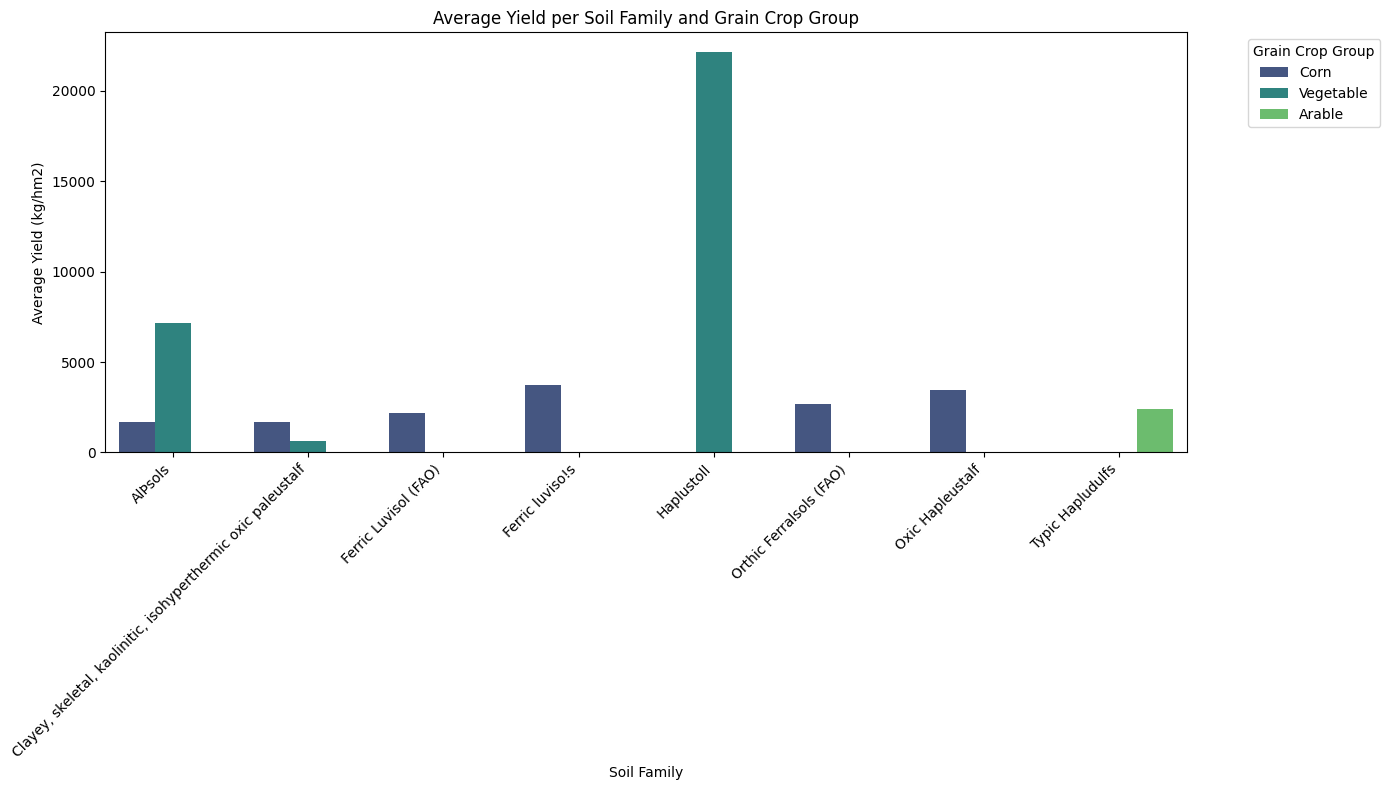

In [14]:
# Aggregate the yield data for each SoilFamily and GrainCropGroup combination
soil_crop_yield = df_top8_soil.groupby(['SoilFamily', 'GrainCropGroup'])['Yield'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(data=soil_crop_yield, x='SoilFamily', y='Yield', hue='GrainCropGroup', palette='viridis')
plt.title('Average Yield per Soil Family and Grain Crop Group')
plt.xlabel('Soil Family')
plt.ylabel('Average Yield (kg/hm2)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Grain Crop Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

There are several issues here, most soil types don't have more than one crop type, which means we can't determine the best, as there is nothing to compare them to. Secondly Haplustoll has a much higher yield than most, which could be from bad data (it could be recorded in other units), or could be using a high intensity technique, such as vertical farming or greenhouses, which doesn't necessarily mean Haplustoll soil is this good for growing vegetables in.

It is better to use soil types which have data on three or more Grain crop groups, to be able to compare them.

In [15]:
# Identify SoilFamily with at least two unique GrainCropGroup entries that have non-null 'Yield' data
soil_family_with_multiple_crops = df_subset_with_yield.groupby('SoilFamily')['GrainCropGroup'].nunique()

# Filter for SoilFamily where the number of unique GrainCropGroup is 2 or more
soil_families_with_multiple_yield_crops = soil_family_with_multiple_crops[soil_family_with_multiple_crops >= 3].index.tolist()

print("Soil Families with Yield data for at least two Grain Crop Groups:")
print(soil_families_with_multiple_yield_crops)

# Create a subset of the original dataframe containing only these SoilFamilies
df_soil_multiple_crops = df_subset_with_yield[df_subset_with_yield['SoilFamily'].isin(soil_families_with_multiple_yield_crops)].copy()

print("\nDataFrame subset for Soil Families with multiple crops:")
print(df_soil_multiple_crops.head())
print(df_soil_multiple_crops.info())

Soil Families with Yield data for at least two Grain Crop Groups:
['Canfield silt loam (fine-loamy, mixed mesic Aquic Fragiudalf)', 'Dystric cambisol on granite bedrock', 'Haplic Luvisols', 'Haplic luvisol on calcareous bedrock', 'Mesic Vertic Epiaqualf', 'Typic Hapludult']

DataFrame subset for Soil Families with multiple crops:
                                            SoilFamily GrainCropGroup  \
440  Canfield silt loam (fine-loamy, mixed mesic Aq...           Corn   
441  Canfield silt loam (fine-loamy, mixed mesic Aq...           Corn   
442  Canfield silt loam (fine-loamy, mixed mesic Aq...           Corn   
443  Canfield silt loam (fine-loamy, mixed mesic Aq...           Corn   
444  Canfield silt loam (fine-loamy, mixed mesic Aq...        Soybean   

    CoverCropGroup    Yield Treatment  Yield_scaled  
440            Rye  11100.0        _T      0.119354  
441            Rye   6700.0        _T      0.072042  
442            Rye  10100.0        _T      0.108601  
443          

In [17]:
df_soil_multiple_crops['SoilFamily'] = df_soil_multiple_crops['SoilFamily'].replace('Canfield silt loam (fine-loamy, mixed mesic Aquic Fragiudalf)', 'Mesic Aquic Fragiudalf')
print(df_soil_multiple_crops['SoilFamily'].unique())

['Mesic Aquic Fragiudalf' 'Dystric cambisol on granite bedrock'
 'Haplic luvisol on calcareous bedrock' 'Mesic Vertic Epiaqualf'
 'Haplic Luvisols' 'Typic Hapludult']


### create bar plot of crops for each soil type

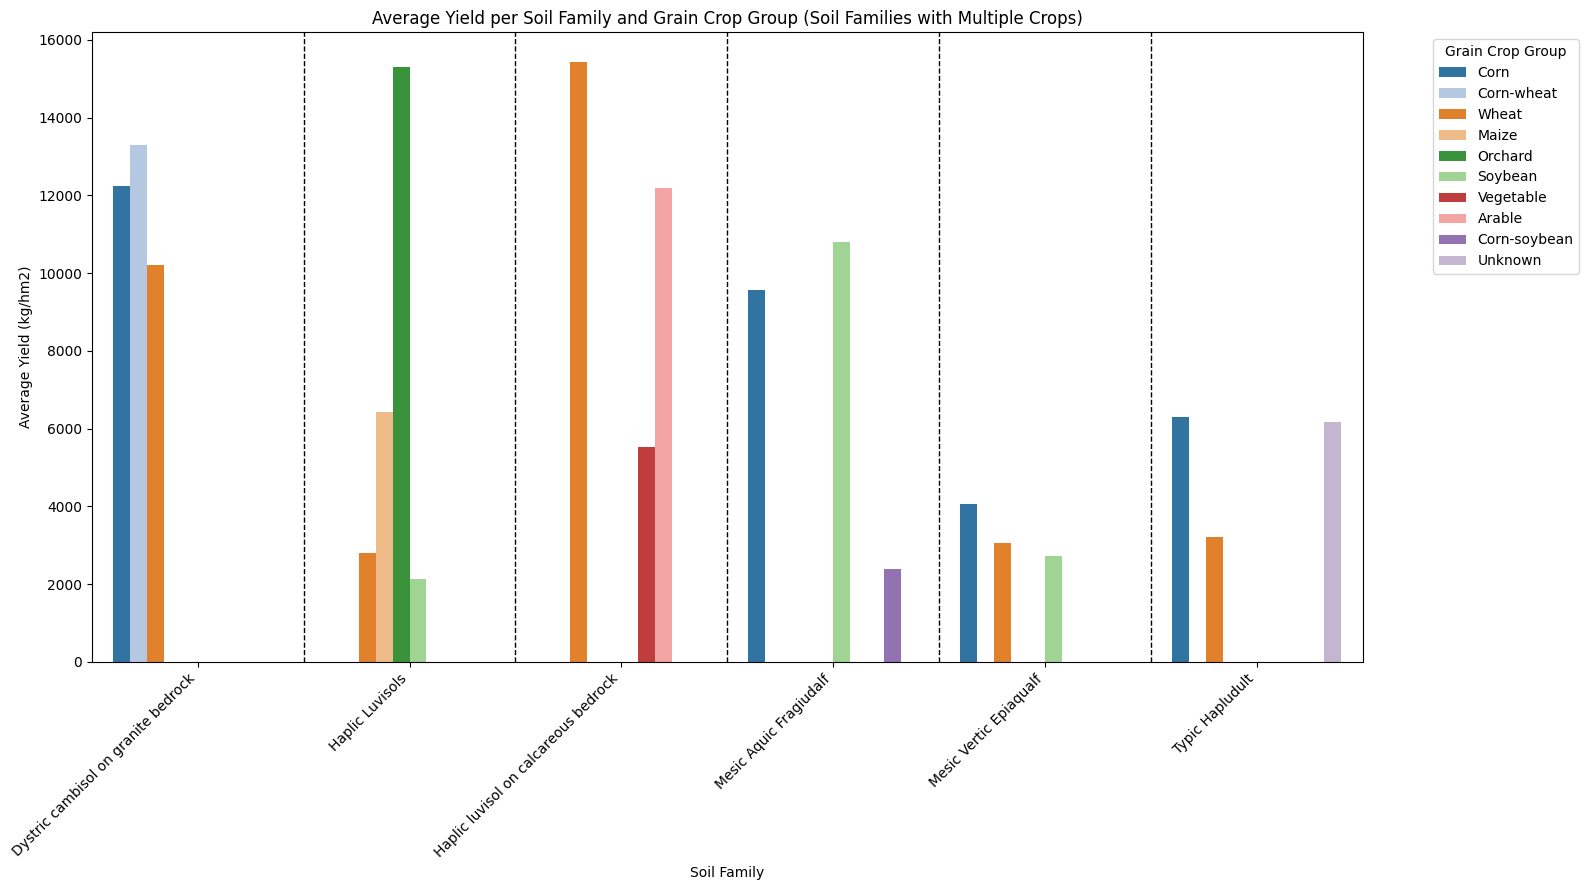

In [18]:
average_yield = df_soil_multiple_crops.groupby(['SoilFamily', 'GrainCropGroup'])['Yield'].mean().reset_index()

# Sort the dataframe by SoilFamily to ensure consistent plotting order
average_yield_sorted = average_yield.sort_values('SoilFamily')

# Create the bar plot
plt.figure(figsize=(16, 9)) # Adjusted figure size for better readability
sns.barplot(data=average_yield_sorted, x='SoilFamily', y='Yield', hue='GrainCropGroup', palette='tab20')

# Set title and labels
plt.title('Average Yield per Soil Family and Grain Crop Group (Soil Families with Multiple Crops)')
plt.xlabel('Soil Family')
plt.ylabel('Average Yield (kg/hm2)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add vertical lines to separate soil types
# Get the unique soil families and their positions on the x-axis
unique_soils = average_yield_sorted['SoilFamily'].unique()
# Add lines after each soil type except the last one
for i in range(len(unique_soils) - 1):
    plt.axvline(x=i + 0.5, color='black', linestyle='--', linewidth=1)

# Add a legend
plt.legend(title='Grain Crop Group', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [19]:
# Find the top GrainCropGroup for each SoilFamily in df_soil_multiple_crops
top_crops_per_soil = df_soil_multiple_crops.loc[df_soil_multiple_crops.groupby('SoilFamily')['Yield'].idxmax()]

print("\nTop GrainCropGroup for each SoilFamily:")
print(top_crops_per_soil[['SoilFamily', 'GrainCropGroup', 'Yield']])


Top GrainCropGroup for each SoilFamily:
                                SoilFamily GrainCropGroup    Yield
509    Dystric cambisol on granite bedrock     Corn-wheat  13450.0
1561                       Haplic Luvisols        Orchard  17250.0
2226  Haplic luvisol on calcareous bedrock          Wheat  15700.0
2157                Mesic Aquic Fragiudalf        Soybean  12300.0
3251                Mesic Vertic Epiaqualf           Corn   6920.0
1653                       Typic Hapludult           Corn  12180.0


Check if top crop group is significantly different to other crop groups in soil family

In [21]:
# Group data by SoilFamily and GrainCropGroup
grouped_yield = df_soil_multiple_crops.groupby(['SoilFamily', 'GrainCropGroup'])['Yield']

# Iterate through each SoilFamily with multiple crops
for soil_family in df_soil_multiple_crops['SoilFamily'].unique():
    print(f"\nAnalyzing SoilFamily: {soil_family}")

    # Get the data for the current SoilFamily
    df_soil = df_soil_multiple_crops[df_soil_multiple_crops['SoilFamily'] == soil_family].copy()

    # Get the top crop for this soil type based on average yield
    top_crop = df_soil.groupby('GrainCropGroup')['Yield'].mean().idxmax()
    print(f"  Top Crop: {top_crop}")

    # Get the yields for the top crop
    yields_top_crop = df_soil[df_soil['GrainCropGroup'] == top_crop]['Yield']

    # Get the yields for all other crops in this soil type
    yields_other_crops = df_soil[df_soil['GrainCropGroup'] != top_crop]['Yield']

    # Perform independent t-test if both groups have enough data
    if len(yields_top_crop) > 1 and len(yields_other_crops) > 1:
        # Before performing t-test, check for equal variances using Levene's test
        # If p-value from Levene's test is < 0.05, assume unequal variances
        try:
            levene_statistic, levene_p_value = stats.levene(yields_top_crop, yields_other_crops)
            equal_var = levene_p_value >= 0.05
            print(f"  Levene's Test p-value: {levene_p_value:.4f} (Assuming equal variances: {equal_var})")

            # Perform t-test
            t_statistic, p_value = stats.ttest_ind(yields_top_crop, yields_other_crops, equal_var=equal_var)

            print(f"  Independent t-test comparing {top_crop} yield to other crop yields:")
            print(f"    T-statistic: {t_statistic:.4f}")
            print(f"    P-value: {p_value:.4f}")

            # Interpret the result
            alpha = 0.05
            if p_value < alpha:
                print(f"    Result: The yield of {top_crop} is significantly different from the yield of other crops in {soil_family} soil (p < {alpha}).")
            else:
                print(f"    Result: There is no statistically significant difference in yield between {top_crop} and other crops in {soil_family} soil (p >= {alpha}).")

        except ValueError as e:
            print(f"  Could not perform t-test for {soil_family}: {e}")
    else:
        print(f"  Not enough data for statistical testing for {soil_family} (need at least 2 samples in each group).")



Analyzing SoilFamily: Mesic Aquic Fragiudalf
  Top Crop: Soybean
  Levene's Test p-value: 0.0164 (Assuming equal variances: False)
  Independent t-test comparing Soybean yield to other crop yields:
    T-statistic: 3.7700
    P-value: 0.0011
    Result: The yield of Soybean is significantly different from the yield of other crops in Mesic Aquic Fragiudalf soil (p < 0.05).

Analyzing SoilFamily: Dystric cambisol on granite bedrock
  Top Crop: Corn-wheat
  Levene's Test p-value: 0.0605 (Assuming equal variances: True)
  Independent t-test comparing Corn-wheat yield to other crop yields:
    T-statistic: 2.2216
    P-value: 0.0904
    Result: There is no statistically significant difference in yield between Corn-wheat and other crops in Dystric cambisol on granite bedrock soil (p >= 0.05).

Analyzing SoilFamily: Haplic luvisol on calcareous bedrock
  Top Crop: Wheat
  Levene's Test p-value: 0.0000 (Assuming equal variances: False)
  Independent t-test comparing Wheat yield to other crop 

## 4.Does the type of cover crop chosen affect the answer for Q3?

Clean each column - make sure there are not duplicate fields

In [54]:
print(df_soil_multiple_crops['CoverCropGroup'].unique())

['Rye' 'Brassica' 'No' 'Mixed']


In [55]:
df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace(['LL', 'Legume_Tree'], 'Legume')
df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace(['LG', 'BG', 'AVG', 'MOT'], 'Mixed')
df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace('Not_available', 'Unknown')
df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace(['No', 'None'], 'No')
df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace('BroadleafTree', 'Broadleaf')

print(df_soil_multiple_crops['CoverCropGroup'].unique())

['Rye' 'Brassica' 'No' 'Mixed']


/tmp/ipython-input-55-3554729350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace(['LL', 'Legume_Tree'], 'Legume')
/tmp/ipython-input-55-3554729350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soil_multiple_crops['CoverCropGroup'] = df_soil_multiple_crops['CoverCropGroup'].replace(['LG', 'BG', 'AVG', 'MOT'], 'Mixed')
/tmp/ipython-input-55-3554729350.py:3: SettingWithCopyWarning: 
A value is trying to be 

In [56]:
df_soil_multiple_crops = df_soil_multiple_crops.dropna()

In [57]:
print(f"Number of records in df_soil_multiple_crops: {len(df_soil_multiple_crops)}")

Number of records in df_soil_multiple_crops: 180


Tthese soil families do not contain legume cover crops, which are found to have the highest influence on soil carbon, though this question does not consider soil carbon directly, legumes are known to fix nitrogen, and so it would be better to have some data on legume cover crops.

### Plots of crop yield per soil family and cover crop

/tmp/ipython-input-26-169645150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_soil_multiple_crops['Scaled_Yield'] = df_soil_multiple_crops.groupby('SoilFamily')['Yield'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())


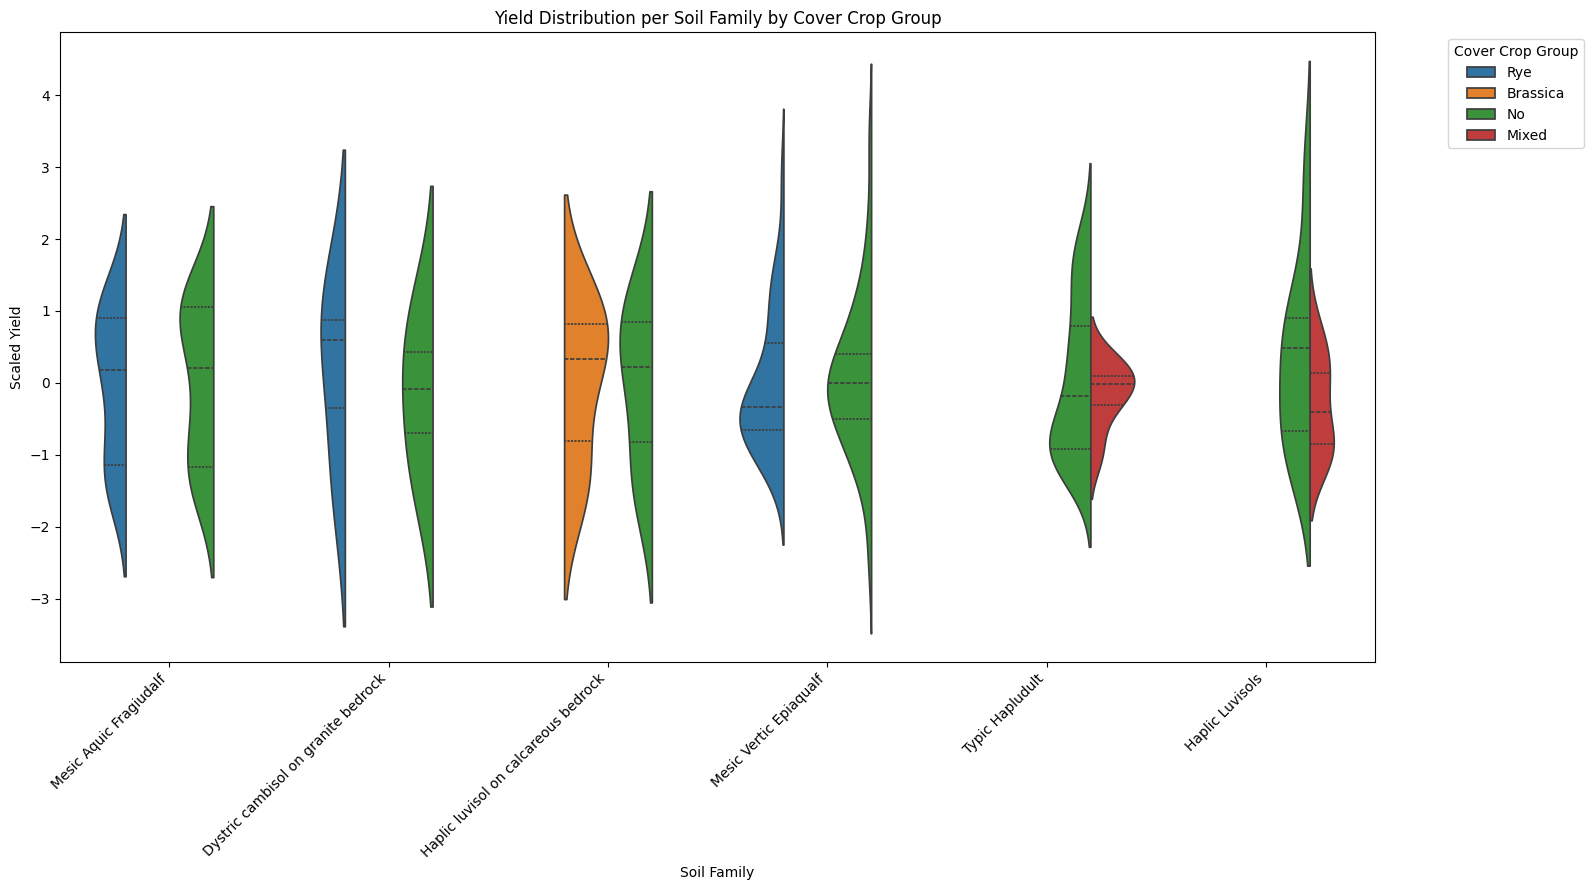

In [26]:

# Group the dataframe by SoilFamily and apply the scaler to the 'Yield' column within each group
df_soil_multiple_crops['Scaled_Yield'] = df_soil_multiple_crops.groupby('SoilFamily')['Yield'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

plt.figure(figsize=(16, 9))
sns.violinplot(data=df_soil_multiple_crops, x='SoilFamily', y='Scaled_Yield', hue='CoverCropGroup', split=True, inner='quart', palette='tab10')

plt.title('Yield Distribution per Soil Family by Cover Crop Group')
plt.xlabel('Soil Family')
plt.ylabel('Scaled Yield')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cover Crop Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

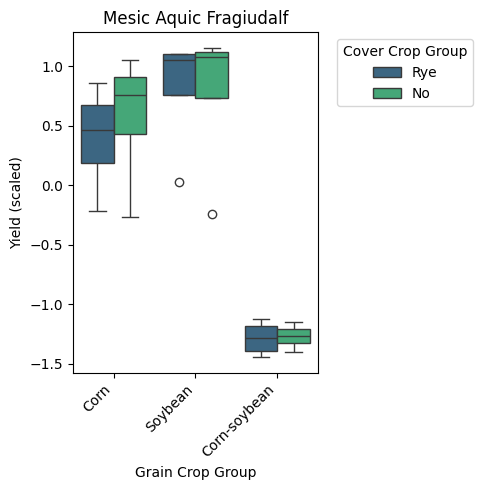

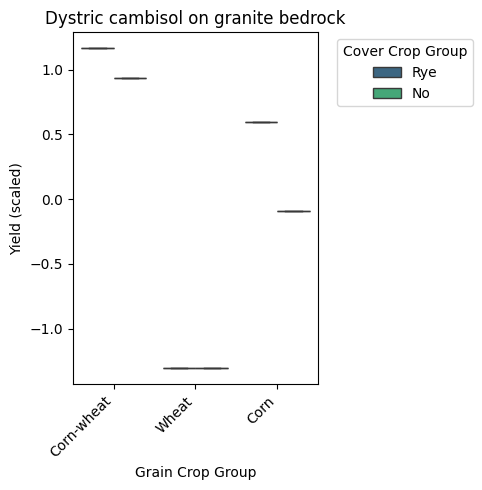

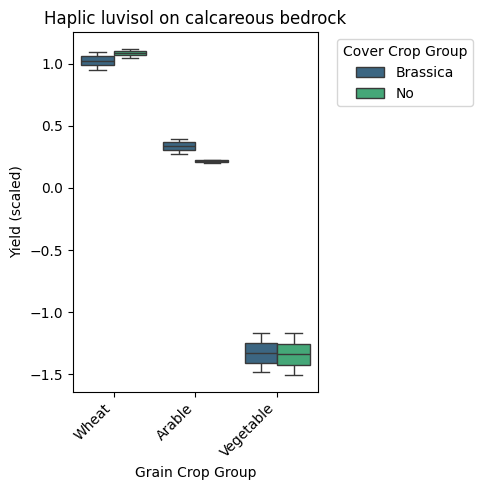

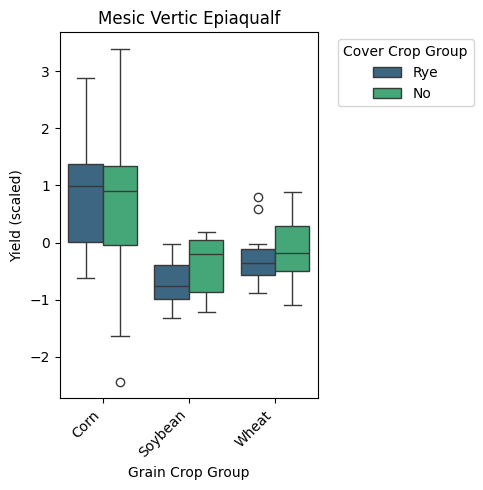

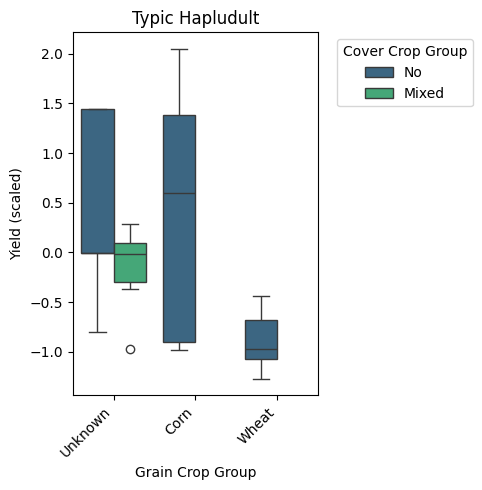

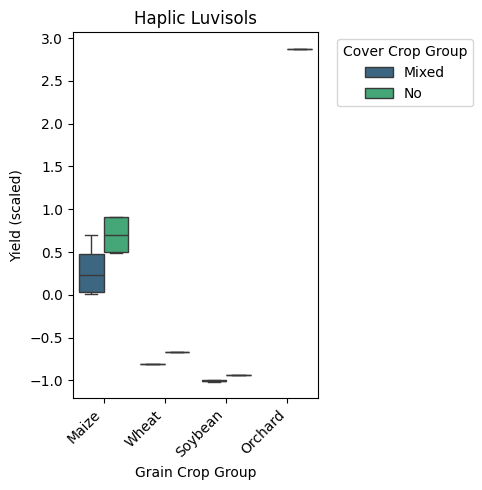

In [27]:
# Iterate through each unique soil family
for soil_family in df_soil_multiple_crops.SoilFamily.unique():
    # Filter data for the current soil family
    df_soil = df_soil_multiple_crops[df_soil_multiple_crops['SoilFamily'] == soil_family]

    # Check if there is data for this soil family
    if not df_soil.empty:
        plt.figure(figsize=(5, 5))
        sns.boxplot(data=df_soil, x='GrainCropGroup', y='Scaled_Yield', hue='CoverCropGroup', palette='viridis')
        plt.title(f'{soil_family}')
        plt.xlabel('Grain Crop Group')
        plt.ylabel('Yield (scaled)')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Cover Crop Group', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data available for SoilFamily: {soil_family}")

### Check significance of yield/grain crop group/cover crop group relationships

In [28]:
# Iterate through each unique SoilFamily
for soil_family in df_soil_multiple_crops['SoilFamily'].unique():
    print(f"\nAnalyzing SoilFamily: {soil_family}")

    # Filter data for the current soil family
    df_soil = df_soil_multiple_crops[df_soil_multiple_crops['SoilFamily'] == soil_family].copy()

    # Check if there is data for this soil family
    if not df_soil.empty:
        # Iterate through each unique GrainCropGroup within this soil family
        for grain_crop_group in df_soil['GrainCropGroup'].unique():
            print(f"  Analyzing GrainCropGroup: {grain_crop_group}")

            # Filter data for the current grain crop group within this soil family
            df_grain_crop = df_soil[df_soil['GrainCropGroup'] == grain_crop_group].copy()

            # Check if there are multiple CoverCropGroups to compare
            if df_grain_crop['CoverCropGroup'].nunique() > 1:
                # Get the unique cover crop groups
                cover_crop_groups = df_grain_crop['CoverCropGroup'].unique()

                # Perform pairwise comparisons between cover crop groups using independent t-tests
                for i in range(len(cover_crop_groups)):
                    for j in range(i + 1, len(cover_crop_groups)):
                        group1 = cover_crop_groups[i]
                        group2 = cover_crop_groups[j]

                        yields_group1 = df_grain_crop[df_grain_crop['CoverCropGroup'] == group1]['Scaled_Yield'].dropna()
                        yields_group2 = df_grain_crop[df_grain_crop['CoverCropGroup'] == group2]['Scaled_Yield'].dropna()

                        # Ensure both groups have enough data for a t-test (at least 2 samples)
                        if len(yields_group1) >= 2 and len(yields_group2) >= 2:
                            try:
                                # Perform Levene's test for equal variances
                                levene_stat, levene_p = stats.levene(yields_group1, yields_group2)
                                equal_var = levene_p >= 0.05 # If p >= 0.05, assume equal variances

                                # Perform independent t-test
                                t_stat, p_value = stats.ttest_ind(yields_group1, yields_group2, equal_var=equal_var)

                                print(f"    Comparison between {group1} and {group2}:")
                                print(f"      Levene's Test p-value: {levene_p:.4f} (Assuming equal variances: {equal_var})")
                                print(f"      Independent t-test p-value: {p_value:.4f}")

                                # Interpret the result
                                alpha = 0.05
                                if p_value < alpha:
                                    print(f"      Result: Scaled_Yield is significantly different between {group1} and {group2} (p < {alpha}).")
                                else:
                                    print(f"      Result: There is no statistically significant difference in Scaled_Yield between {group1} and {group2} (p >= {alpha}).")

                            except ValueError as e:
                                print(f"      Could not perform t-test for {group1} vs {group2}: {e}")
                        else:
                            print(f"    Not enough data to compare {group1} and {group2} (need at least 2 samples in each group).")

            elif df_grain_crop['CoverCropGroup'].nunique() == 1:
                 print(f"  Only one CoverCropGroup ('{df_grain_crop['CoverCropGroup'].iloc[0]}') for {grain_crop_group}. Cannot perform comparison.")
            else:
                 print(f"  No CoverCropGroup data available for {grain_crop_group}.")

    else:
        print(f"No data available for SoilFamily: {soil_family}")



Analyzing SoilFamily: Mesic Aquic Fragiudalf
  Analyzing GrainCropGroup: Corn
    Comparison between Rye and No:
      Levene's Test p-value: 0.8904 (Assuming equal variances: True)
      Independent t-test p-value: 0.6403
      Result: There is no statistically significant difference in Scaled_Yield between Rye and No (p >= 0.05).
  Analyzing GrainCropGroup: Soybean
    Comparison between Rye and No:
      Levene's Test p-value: 0.8729 (Assuming equal variances: True)
      Independent t-test p-value: 0.9234
      Result: There is no statistically significant difference in Scaled_Yield between Rye and No (p >= 0.05).
  Analyzing GrainCropGroup: Corn-soybean
    Comparison between Rye and No:
      Levene's Test p-value: 0.2413 (Assuming equal variances: True)
      Independent t-test p-value: 0.8458
      Result: There is no statistically significant difference in Scaled_Yield between Rye and No (p >= 0.05).

Analyzing SoilFamily: Dystric cambisol on granite bedrock
  Analyzing Grain

/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3057: RuntimeWarning: divide by zero encountered in scalar divide
  W = numer / denom


In [29]:
# Apply Shapiro-Wilk test to check for normality of Scaled_Yield
# Iterate through each unique SoilFamily and GrainCropGroup combination with sufficient data
for soil_family in df_soil_multiple_crops['SoilFamily'].unique():
    for grain_crop_group in df_soil_multiple_crops[df_soil_multiple_crops['SoilFamily'] == soil_family]['GrainCropGroup'].unique():
        # Filter data for the current combination
        df_combination = df_soil_multiple_crops[(df_soil_multiple_crops['SoilFamily'] == soil_family) & (df_soil_multiple_crops['GrainCropGroup'] == grain_crop_group)].copy()

        # Check if there's enough data (at least 3 samples are generally recommended for Shapiro-Wilk)
        if len(df_combination) >= 3:
            # Get the Scaled_Yield data
            scaled_yield_data = df_combination['Scaled_Yield'].dropna()

            if len(scaled_yield_data) >= 3:
                # Perform Shapiro-Wilk test
                try:
                    shapiro_statistic, shapiro_p_value = stats.shapiro(scaled_yield_data)

                    print(f"\nShapiro-Wilk Test for SoilFamily: {soil_family}, GrainCropGroup: {grain_crop_group}")
                    print(f"  Shapiro-Wilk Statistic: {shapiro_statistic:.4f}")
                    print(f"  P-value: {shapiro_p_value:.4f}")

                    # Interpret the result
                    alpha = 0.05
                    if shapiro_p_value < alpha:
                        print(f"  Result: The Scaled_Yield distribution for this combination is likely not normal (p < {alpha}).")
                    else:
                        print(f"  Result: The Scaled_Yield distribution for this combination is likely normal (p >= {alpha}).")

                except Exception as e:
                    print(f"  Could not perform Shapiro-Wilk test for SoilFamily: {soil_family}, GrainCropGroup: {grain_crop_group}: {e}")
            else:
                print(f"\nNot enough non-null data (need at least 3) for Shapiro-Wilk Test for SoilFamily: {soil_family}, GrainCropGroup: {grain_crop_group}")
        else:
            print(f"\nNot enough data (need at least 3 samples) for Shapiro-Wilk Test for SoilFamily: {soil_family}, GrainCropGroup: {grain_crop_group}")




Shapiro-Wilk Test for SoilFamily: Mesic Aquic Fragiudalf, GrainCropGroup: Corn
  Shapiro-Wilk Statistic: 0.8803
  P-value: 0.1895
  Result: The Scaled_Yield distribution for this combination is likely normal (p >= 0.05).

Shapiro-Wilk Test for SoilFamily: Mesic Aquic Fragiudalf, GrainCropGroup: Soybean
  Shapiro-Wilk Statistic: 0.6621
  P-value: 0.0008
  Result: The Scaled_Yield distribution for this combination is likely not normal (p < 0.05).

Shapiro-Wilk Test for SoilFamily: Mesic Aquic Fragiudalf, GrainCropGroup: Corn-soybean
  Shapiro-Wilk Statistic: 0.9362
  P-value: 0.5742
  Result: The Scaled_Yield distribution for this combination is likely normal (p >= 0.05).

Not enough data (need at least 3 samples) for Shapiro-Wilk Test for SoilFamily: Dystric cambisol on granite bedrock, GrainCropGroup: Corn-wheat

Not enough data (need at least 3 samples) for Shapiro-Wilk Test for SoilFamily: Dystric cambisol on granite bedrock, GrainCropGroup: Wheat

Not enough data (need at least 3 s

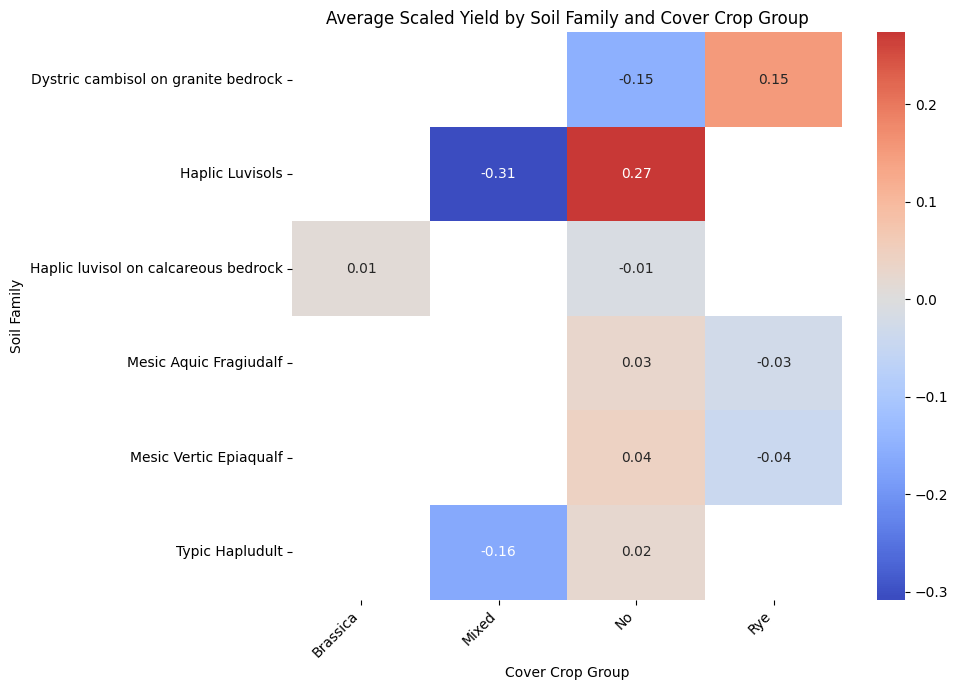

In [30]:
# Create a new dataframe for correlation analysis
df_correlation = df_soil_multiple_crops[['SoilFamily', 'CoverCropGroup', 'Scaled_Yield']].copy()

# Pivot table for heatmap visualization
# We will calculate the average scaled yield for each combination of SoilFamily and CoverCropGroup
heatmap_data = df_correlation.pivot_table(index='SoilFamily', columns='CoverCropGroup', values='Scaled_Yield', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Average Scaled Yield by Soil Family and Cover Crop Group')
plt.xlabel('Cover Crop Group')
plt.ylabel('Soil Family')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## additionally, analyse to check if cover crops effect crop yield (not considering soil family)


One-Way ANOVA: Effect of CoverCropGroup on Yield_scaled (ignoring SoilFamily)
                      sum_sq      df         F        PR(>F)
C(CoverCropGroup)   0.940988    14.0  6.297956  1.290184e-12
Residual           35.517279  3328.0       NaN           NaN
  Result: The mean scaled yield is significantly different across different CoverCropGroups (p < 0.05).


/tmp/ipython-input-42-3933671685.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0] # Get the p-value for CoverCropGroup


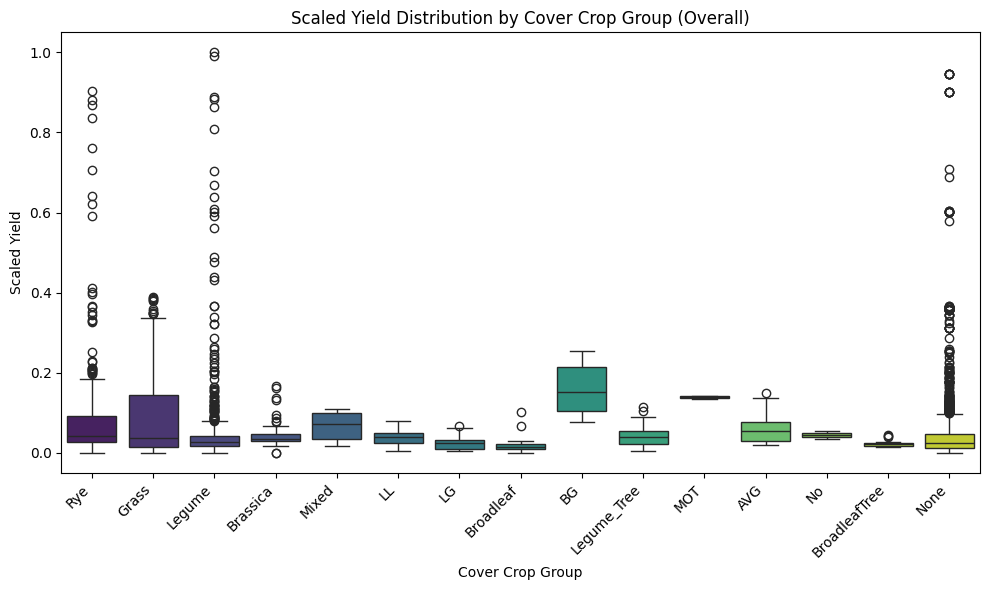

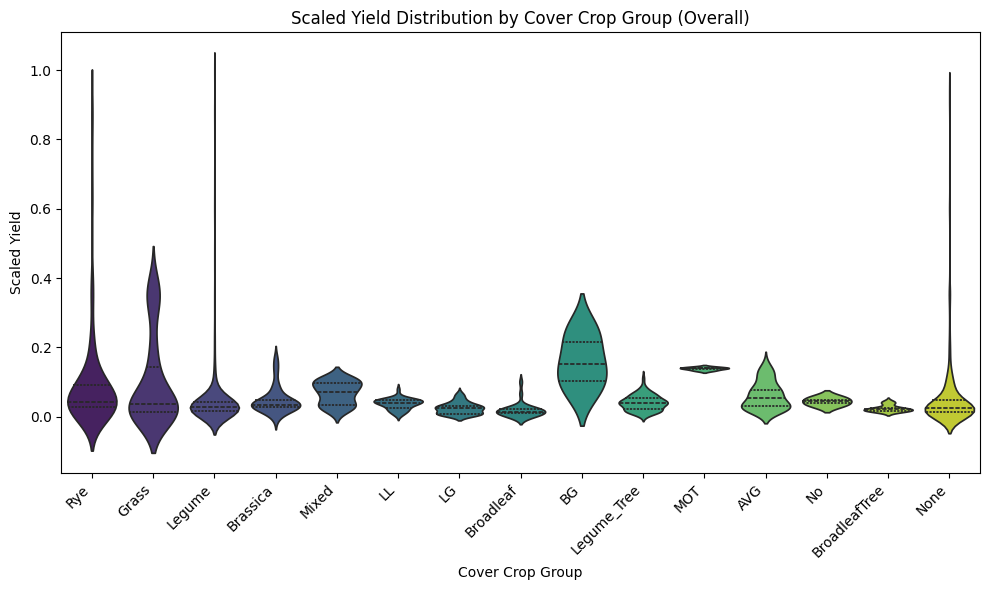

In [42]:
# Ensure 'CoverCropGroup' and 'Scaled_Yield' columns are present and have no missing values for this analysis
df_subset_anova = df_subset[['CoverCropGroup', 'Yield_scaled']].dropna().copy()

# Perform One-Way ANOVA
# The formula 'Scaled_Yield ~ C(CoverCropGroup)' specifies Scaled_Yield as the dependent variable
# and CoverCropGroup as the independent categorical variable. C() indicates that CoverCropGroup should be treated as categorical.
try:
    model = ols('Yield_scaled ~ C(CoverCropGroup)', data=df_subset_anova).fit()
    anova_table = sm.stats.anova_lm(model, typ=2) # Type 2 ANOVA

    print("\nOne-Way ANOVA: Effect of CoverCropGroup on Yield_scaled (ignoring SoilFamily)")
    print(anova_table)

    # Interpret the ANOVA result
    alpha = 0.05
    p_value = anova_table['PR(>F)'][0] # Get the p-value for CoverCropGroup

    if p_value < alpha:
        print(f"  Result: The mean scaled yield is significantly different across different CoverCropGroups (p < {alpha}).")
    else:
        print(f"  Result: There is no statistically significant difference in mean scaled yield across different CoverCropGroups (p >= {alpha}).")

except Exception as e:
    print(f"\nCould not perform One-Way ANOVA: {e}")
    print("Please ensure 'CoverCropGroup' is a valid column and 'Scaled_Yield' has been calculated correctly on df_subset.")

# To visualize this, we can use a boxplot or violin plot of Scaled_Yield by CoverCropGroup
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_subset_anova, x='CoverCropGroup', y='Yield_scaled',hue='CoverCropGroup',  palette='viridis')
plt.title('Scaled Yield Distribution by Cover Crop Group (Overall)')
plt.xlabel('Cover Crop Group')
plt.ylabel('Scaled Yield')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_subset_anova, x='CoverCropGroup', y='Yield_scaled', hue='CoverCropGroup', palette='viridis', inner='quart')
plt.title('Scaled Yield Distribution by Cover Crop Group (Overall)')
plt.xlabel('Cover Crop Group')
plt.ylabel('Scaled Yield')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
